In [1]:
import sys 
import os
import dvc.api
import warnings
warnings.filterwarnings('ignore')
sys.path.append(os.path.abspath(os.path.join('data')))
sys.path.insert(0,'../scripts_/')
sys.setrecursionlimit(5000)

# Importing Pandas an Numpy Libraries to use on manipulating our Data
import pandas as pd
import numpy as np


# To fill missing values
from sklearn.impute import SimpleImputer



# To Visualize Data
import matplotlib.pyplot as plt
import seaborn as sns

# To Train our data
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.model_selection import KFold

# To evaluate end result we have
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score

In [2]:
from utils import Utils
import models
from data_cleaning import DataCleaning

utils = Utils()

### Load Data

In [3]:
df = utils.load_data('../data/AdSmartABdata.csv')

In [4]:
df.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


Extract columns with yes or no response

In [5]:
cleaner = DataCleaning(df)
responded_df = cleaner.response(df)
responded_df.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
16,008aafdf-deef-4482-8fec-d98e3da054da,exposed,2020-07-04,16,Generic Smartphone,6,Chrome Mobile,1,0
23,00b6fadb-10bd-49e3-a778-290da82f7a8d,control,2020-07-08,4,Samsung SM-A202F,6,Facebook,1,0
45,018af862-486e-4da1-a85b-71872120e57c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,1,0
65,023ec7b5-cb8f-49a5-995f-e0d7c2f702e5,exposed,2020-07-09,13,Samsung SM-G935F,6,Facebook,1,0
89,02efdb70-8596-4f3f-b0b2-b91e194f61f7,exposed,2020-07-05,6,Generic Smartphone,6,Chrome Mobile,1,0


##### Merge yes and no columns into aware column

In [6]:
responded_df['aware'] = responded_df['yes'].map(lambda x: 1 if x == 1 else 0)
responded_df = responded_df.drop(columns=['yes', 'no'])
responded_df.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,aware
16,008aafdf-deef-4482-8fec-d98e3da054da,exposed,2020-07-04,16,Generic Smartphone,6,Chrome Mobile,1
23,00b6fadb-10bd-49e3-a778-290da82f7a8d,control,2020-07-08,4,Samsung SM-A202F,6,Facebook,1
45,018af862-486e-4da1-a85b-71872120e57c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,1
65,023ec7b5-cb8f-49a5-995f-e0d7c2f702e5,exposed,2020-07-09,13,Samsung SM-G935F,6,Facebook,1
89,02efdb70-8596-4f3f-b0b2-b91e194f61f7,exposed,2020-07-05,6,Generic Smartphone,6,Chrome Mobile,1


Split dataframe as browser_only and platform_os only

In [7]:
browser_df = responded_df[['hour','date', 'device_make', 'browser', 'aware', 'experiment']]
platform_df = responded_df[['hour','date', 'device_make', 'platform_os', 'aware', 'experiment']]

In [8]:
browser_df.head()

,hour,date,device_make,browser,aware,experiment
16,16,2020-07-04,Generic Smartphone,Chrome Mobile,1,exposed
23,4,2020-07-08,Samsung SM-A202F,Facebook,1,control
45,15,2020-07-03,Generic Smartphone,Chrome Mobile,1,control
65,13,2020-07-09,Samsung SM-G935F,Facebook,1,exposed
89,6,2020-07-05,Generic Smartphone,Chrome Mobile,1,exposed


In [9]:
platform_df.head()

,hour,date,device_make,platform_os,aware,experiment
16,16,2020-07-04,Generic Smartphone,6,1,exposed
23,4,2020-07-08,Samsung SM-A202F,6,1,control
45,15,2020-07-03,Generic Smartphone,6,1,control
65,13,2020-07-09,Samsung SM-G935F,6,1,exposed
89,6,2020-07-05,Generic Smartphone,6,1,exposed


In [10]:
android = platform_df.groupby('platform_os').get_group(6)
ios = platform_df.groupby('platform_os').get_group(5)

In [11]:
utils.save_csv(android, '../data/platform_os_android.csv')
utils.save_csv(ios, '../data/platform_os_ios.csv')

File Successfully Saved.!!!
File Successfully Saved.!!!


,hour,date,device_make,platform_os,aware,experiment
3240,3,2020-07-04,iPhone,5,1,control
3843,3,2020-07-05,iPhone,5,1,exposed
5278,9,2020-07-09,iPhone,5,1,control
7095,5,2020-07-09,iPhone,5,1,control
7465,11,2020-07-04,iPhone,5,1,control
1097,8,2020-07-03,iPhone,5,0,exposed
2630,15,2020-07-03,iPhone,5,0,control
2631,15,2020-07-03,iPhone,5,0,control
4245,5,2020-07-08,iPhone,5,0,exposed
4706,14,2020-07-10,iPhone,5,0,control


In [12]:
browser_df.groupby('browser').count()

,hour,date,device_make,aware,experiment
browser,,,,,
Chrome,2,2,2,2,2
Chrome Mobile,695,695,695,695,695
Chrome Mobile WebView,227,227,227,227,227
Chrome Mobile iOS,1,1,1,1,1
Facebook,156,156,156,156,156
Mobile Safari,14,14,14,14,14
Mobile Safari UI/WKWebView,3,3,3,3,3
Samsung Internet,145,145,145,145,145


The most common browsers are Chrome Mobile and Chrome Mobile WebView so we'll extract the two groups

In [13]:
chrome_mobile = browser_df.groupby('browser').get_group('Chrome Mobile')
chrome_mobile_webview = browser_df.groupby('browser').get_group('Chrome Mobile WebView')

In [14]:
utils.save_csv(chrome_mobile, '../data/browser_chrome_mobile.csv')
utils.save_csv(chrome_mobile_webview, '../data/browser_chrome_mobile_webview.csv')

File Successfully Saved.!!!
File Successfully Saved.!!!


,hour,date,device_make,browser,aware,experiment
128,11,2020-07-04,Samsung SM-G981B,Chrome Mobile WebView,1,exposed
144,2,2020-07-05,Generic Smartphone,Chrome Mobile WebView,1,exposed
241,20,2020-07-08,Generic Smartphone,Chrome Mobile WebView,1,exposed
357,15,2020-07-03,Samsung SM-A202F,Chrome Mobile WebView,1,control
358,21,2020-07-08,Samsung SM-A405FN,Chrome Mobile WebView,1,exposed
...,...,...,...,...,...,...
7479,13,2020-07-03,Generic Smartphone,Chrome Mobile WebView,0,exposed
7596,8,2020-07-09,Pixel 2,Chrome Mobile WebView,0,exposed
7768,14,2020-07-08,Generic Smartphone,Chrome Mobile WebView,0,exposed
7901,8,2020-07-10,Samsung SM-A300FU,Chrome Mobile WebView,0,exposed


#### Data Preparation

In [15]:
responded_df = responded_df.drop(columns='auction_id')
responded_df.head()


,experiment,date,hour,device_make,platform_os,browser,aware
16,exposed,2020-07-04,16,Generic Smartphone,6,Chrome Mobile,1
23,control,2020-07-08,4,Samsung SM-A202F,6,Facebook,1
45,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,1
65,exposed,2020-07-09,13,Samsung SM-G935F,6,Facebook,1
89,exposed,2020-07-05,6,Generic Smartphone,6,Chrome Mobile,1


#### Import 4 classes of data and prepare for model building

In [16]:
platform_android = utils.load_data_dvc('v2', 'data/platform_os_android.csv', '/home/teddy/dev/learning/10 academy/working/AB-Hypohesis-Testing_mlops')
platform_ios = utils.load_data_dvc('v3', 'data/platform_os_ios.csv', '/home/teddy/dev/learning/10 academy/working/AB-Hypohesis-Testing_mlops')
browser_chromemobile = utils.load_data_dvc('v4', 'data/browser_chrome_mobile.csv', '/home/teddy/dev/learning/10 academy/working/AB-Hypohesis-Testing_mlops')
browser_chromemobile_webview = utils.load_data_dvc('v5', 'data/browser_chrome_mobile_webview.csv', '/home/teddy/dev/learning/10 academy/working/AB-Hypohesis-Testing_mlops')

Encode data

In [17]:
enc_platform_android = Utils.encode_features(platform_android)
enc_platform_ios = Utils.encode_features(platform_ios)
enc_browser_chromemobile = Utils.encode_features(browser_chromemobile)
enc_browser_chromemobile_webview = Utils.encode_features(browser_chromemobile_webview)

##### 1.1 Decision Tree using platfrom_android

In [18]:
feature_cols = ['experiment', 'device_make', 'hour', 'platform_os', 'date']
X = enc_platform_android[feature_cols]
Y = enc_platform_android[['aware']]

split_size = (.7, .2, .1)
X_train, X_test, y_train, y_test, val_x,val_y = Utils.split_train_test_val(X, Y, split_size)

In [19]:
decisionTreeModel = models.DecisionTreeModel(X_train, y_train, X_test, y_test)
folds = 5
model, accuracy, confusion_matrix = decisionTreeModel.train(folds,'DecisionTree experiment with platform_android data')

step 0: Validation Accuracy of DecisionTreesModel is: 0.576
step 0: Validation Loss of DecisionTreesModel is: 0.651

step 1: Validation Accuracy of DecisionTreesModel is: 0.517
step 1: Validation Loss of DecisionTreesModel is: 0.695

step 2: Validation Accuracy of DecisionTreesModel is: 0.564
step 2: Validation Loss of DecisionTreesModel is: 0.660

step 3: Validation Accuracy of DecisionTreesModel is: 0.550
step 3: Validation Loss of DecisionTreesModel is: 0.671

step 4: Validation Accuracy of DecisionTreesModel is: 0.520
step 4: Validation Loss of DecisionTreesModel is: 0.692



Registered model 'platform_android' already exists. Creating a new version of this model...
2022/05/21 18:45:21 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: platform_android, version 3
Created version '3' of model 'platform_android'.


Run - Summary is logged to Experiment - DecisionTree with Platform_os Android


{'accuracy': 0.52,
 'precision': 0.63,
 'recall': 0.26,
 'true_pos': 47,
 'true_neg': 17,
 'false_pos': 10,
 'false_neg': 49}

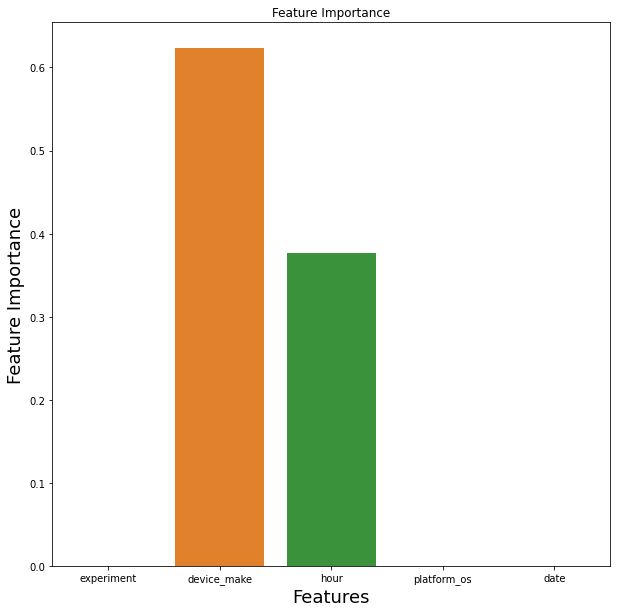

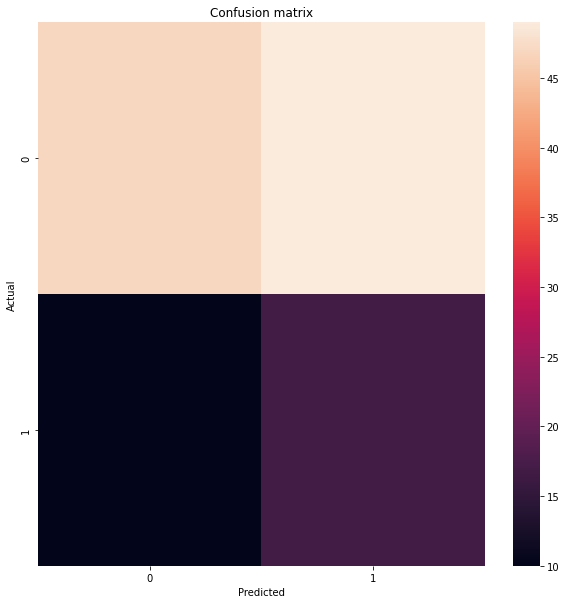

In [20]:
decisionTreeModel.log_model(val_x, val_y, "DecisionTree with Platform_os Android", 'Summary', 'platform_android')

,feature,feature_importances
0,experiment,0.000000
1,device_make,0.623189
2,hour,0.376811
3,platform_os,0.000000
4,date,0.000000


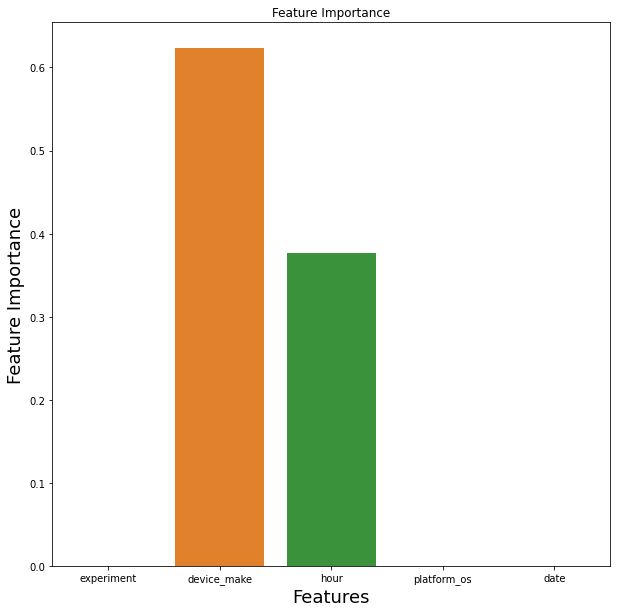

In [21]:
feature_importance,_ = decisionTreeModel.get_feature_importance()
feature_importance

For our data platform android the relevant features are device_make and hour while date and experiment have no significance. The decision tree uses a maximum depth of 4.

##### 1.2 Decision Tree using platfrom_ios

In [22]:
feature_cols = ['experiment', 'device_make', 'hour', 'platform_os', 'date']
X = enc_platform_ios[feature_cols]
Y = enc_platform_ios[['aware']]

split_size = (.7, .2, .1)
X_train, X_test, y_train, y_test, val_x,val_y = Utils.split_train_test_val(X, Y, split_size)

In [23]:
decisionTreeModel = models.DecisionTreeModel(X_train, y_train, X_test, y_test)
folds = 5
model, accuracy, confusion_matrix = decisionTreeModel.train(folds,'DecisionTree experiment with platform_ios data')

step 0: Validation Accuracy of DecisionTreesModel is: 0.667
step 0: Validation Loss of DecisionTreesModel is: 0.577

step 1: Validation Accuracy of DecisionTreesModel is: 1.000
step 1: Validation Loss of DecisionTreesModel is: 0.000

step 2: Validation Accuracy of DecisionTreesModel is: 1.000
step 2: Validation Loss of DecisionTreesModel is: 0.000

step 3: Validation Accuracy of DecisionTreesModel is: 0.500
step 3: Validation Loss of DecisionTreesModel is: 0.707

step 4: Validation Accuracy of DecisionTreesModel is: 1.000
step 4: Validation Loss of DecisionTreesModel is: 0.000



Registered model 'platform_ios' already exists. Creating a new version of this model...
2022/05/21 18:45:36 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: platform_ios, version 2
Created version '2' of model 'platform_ios'.


Run - Summary is logged to Experiment - DecisionTree with Platform_os IOS


{'accuracy': 0.5,
 'precision': 1.0,
 'recall': 0.5,
 'true_pos': 0,
 'true_neg': 1,
 'false_pos': 0,
 'false_neg': 1}

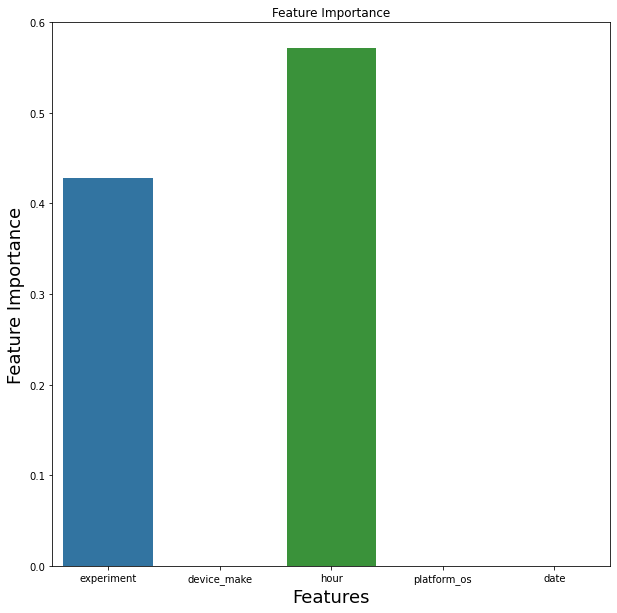

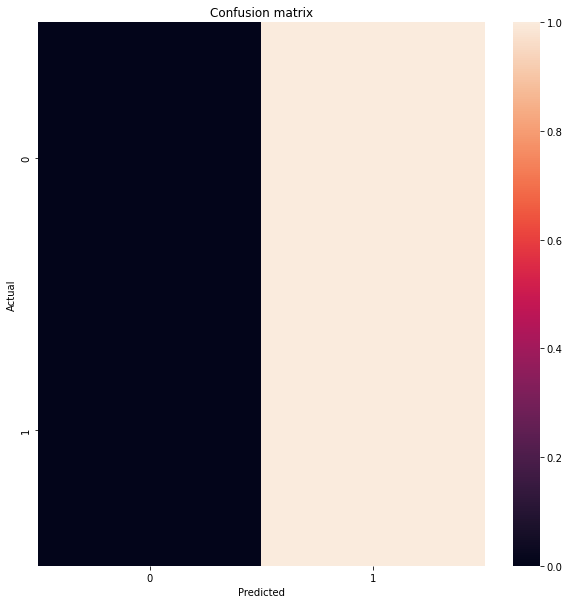

In [24]:
decisionTreeModel.log_model(val_x, val_y, "DecisionTree with Platform_os IOS", 'Summary', 'platform_ios')

,feature,feature_importances
0,experiment,0.428571
1,device_make,0.000000
2,hour,0.571429
3,platform_os,0.000000
4,date,0.000000


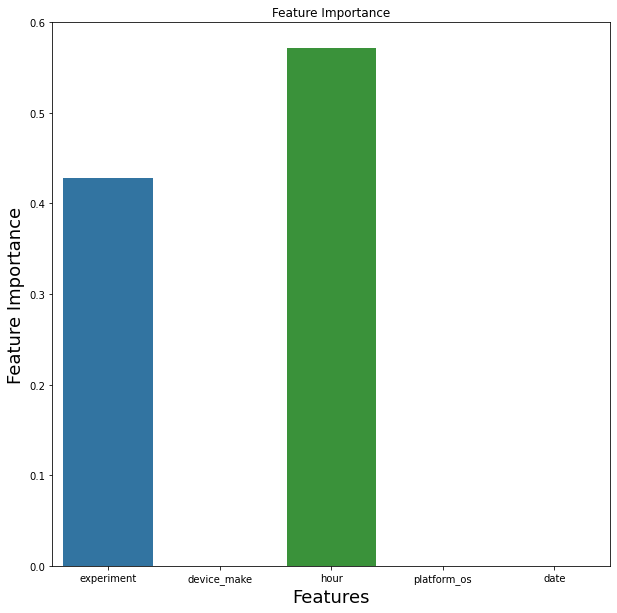

In [25]:
feature_importance,_ = decisionTreeModel.get_feature_importance()
feature_importance

For our dataset platform_ios the hour feature is the only driving feature in our decision tree model

##### 1.3 Decision Tree using browser_chrome_mobile dataset

In [26]:
feature_cols = ['experiment', 'device_make', 'hour', 'browser', 'date']
X = enc_browser_chromemobile[feature_cols]
Y = enc_browser_chromemobile[['aware']]

split_size = (.7, .2, .1)
X_train, X_test, y_train, y_test, val_x,val_y = Utils.split_train_test_val(X, Y, split_size)

In [27]:
decisionTreeModel = models.DecisionTreeModel(X_train, y_train, X_test, y_test)
folds = 5
model, accuracy, confusion_matrix = decisionTreeModel.train(folds,'DecisionTree experiment with browser_chrome_mobile data')

step 0: Validation Accuracy of DecisionTreesModel is: 0.480
step 0: Validation Loss of DecisionTreesModel is: 0.721

step 1: Validation Accuracy of DecisionTreesModel is: 0.567
step 1: Validation Loss of DecisionTreesModel is: 0.658

step 2: Validation Accuracy of DecisionTreesModel is: 0.495
step 2: Validation Loss of DecisionTreesModel is: 0.711

step 3: Validation Accuracy of DecisionTreesModel is: 0.608
step 3: Validation Loss of DecisionTreesModel is: 0.626

step 4: Validation Accuracy of DecisionTreesModel is: 0.536
step 4: Validation Loss of DecisionTreesModel is: 0.681



Registered model 'browser_chrome_mobile' already exists. Creating a new version of this model...
2022/05/21 18:45:56 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: browser_chrome_mobile, version 2
Created version '2' of model 'browser_chrome_mobile'.


Run - Summary is logged to Experiment - DecisionTree with browser chrome_mobile


{'accuracy': 0.47,
 'precision': 0.0,
 'recall': 0.0,
 'true_pos': 33,
 'true_neg': 0,
 'false_pos': 0,
 'false_neg': 37}

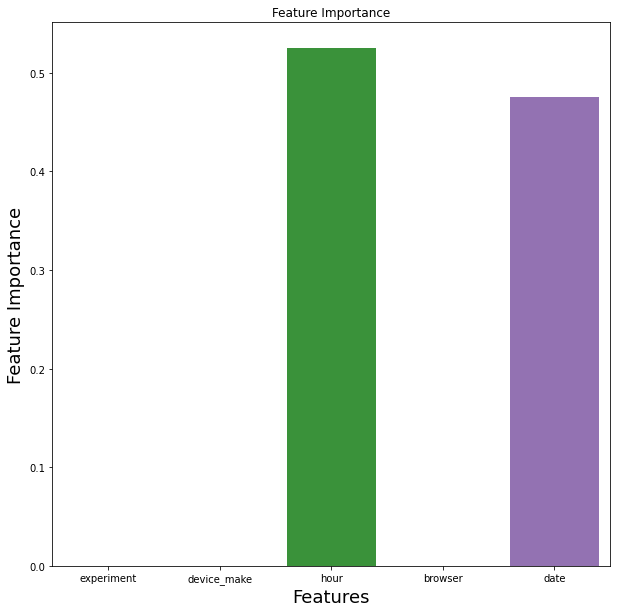

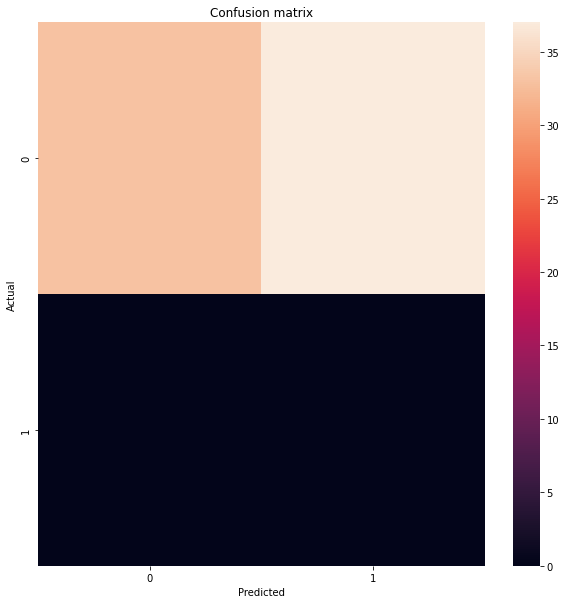

In [28]:
decisionTreeModel.log_model(val_x, val_y, "DecisionTree with browser chrome_mobile", 'Summary', 'browser_chrome_mobile')

,feature,feature_importances
0,experiment,0.000000
1,device_make,0.000000
2,hour,0.524822
3,browser,0.000000
4,date,0.475178


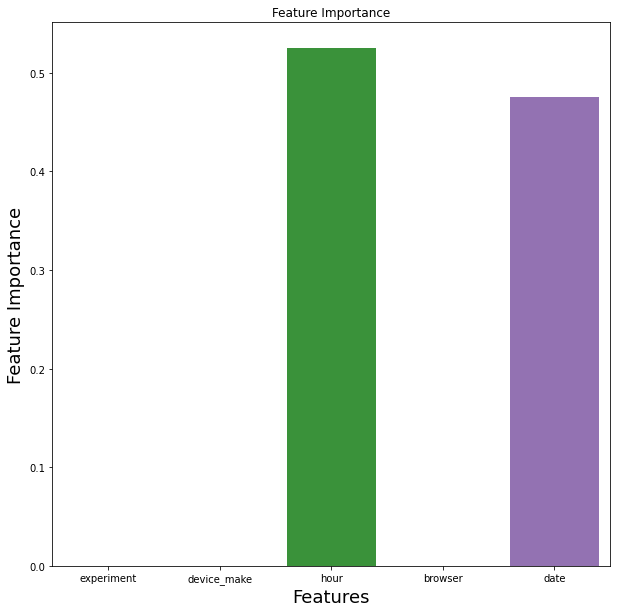

In [29]:
feature_importance,_ = decisionTreeModel.get_feature_importance()
feature_importance

For our dataset browser_chrome_mobile the most important features are hour and date. Hour is the most important feature in this decision tree model. The remaining features don't have any contribution

##### 1.4 Decision Tree using browser_chrome_mobile_webview dataset

In [30]:
feature_cols = ['experiment', 'device_make', 'hour', 'browser', 'date']
X = enc_browser_chromemobile_webview[feature_cols]
Y = enc_browser_chromemobile_webview[['aware']]

split_size = (.7, .2, .1)
X_train, X_test, y_train, y_test, val_x,val_y = Utils.split_train_test_val(X, Y, split_size)

In [31]:
decisionTreeModel = models.DecisionTreeModel(X_train, y_train, X_test, y_test)
folds = 5
model, accuracy, confusion_matrix = decisionTreeModel.train(folds,'DecisionTree experiment with browser_chrome_mobile_webview data')

step 0: Validation Accuracy of DecisionTreesModel is: 0.406
step 0: Validation Loss of DecisionTreesModel is: 0.771

step 1: Validation Accuracy of DecisionTreesModel is: 0.500
step 1: Validation Loss of DecisionTreesModel is: 0.707

step 2: Validation Accuracy of DecisionTreesModel is: 0.531
step 2: Validation Loss of DecisionTreesModel is: 0.685

step 3: Validation Accuracy of DecisionTreesModel is: 0.581
step 3: Validation Loss of DecisionTreesModel is: 0.648

step 4: Validation Accuracy of DecisionTreesModel is: 0.581
step 4: Validation Loss of DecisionTreesModel is: 0.648



Registered model 'browser_chrome_mobile_webview' already exists. Creating a new version of this model...
2022/05/21 18:46:14 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: browser_chrome_mobile_webview, version 2
Created version '2' of model 'browser_chrome_mobile_webview'.


Run - Summary is logged to Experiment - DecisionTree with browser chrome_mobile_webview


{'accuracy': 0.61,
 'precision': 0.75,
 'recall': 0.46,
 'true_pos': 8,
 'true_neg': 6,
 'false_pos': 2,
 'false_neg': 7}

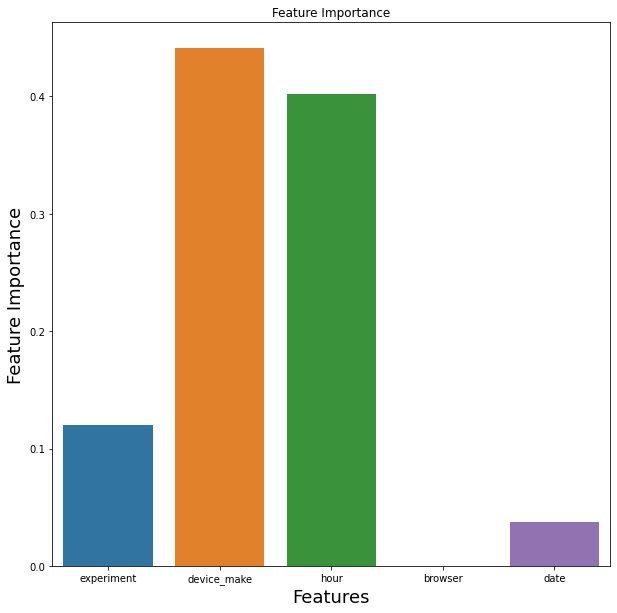

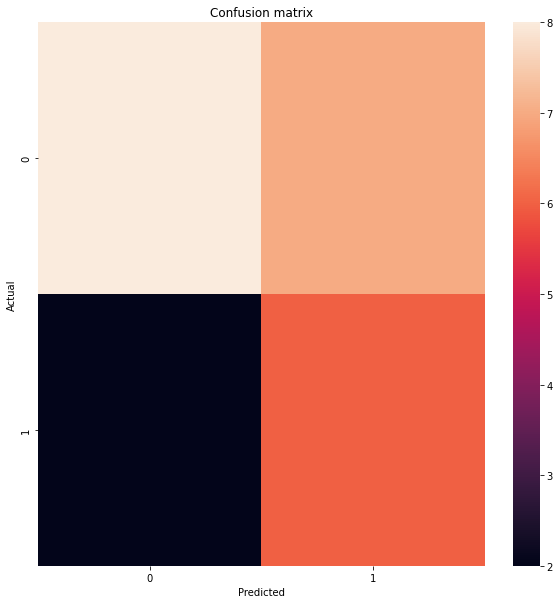

In [32]:
decisionTreeModel.log_model(val_x, val_y, "DecisionTree with browser chrome_mobile_webview", 'Summary', 'browser_chrome_mobile_webview')

,feature,feature_importances
0,experiment,0.119861
1,device_make,0.441143
2,hour,0.401986
3,browser,0.000000
4,date,0.037011


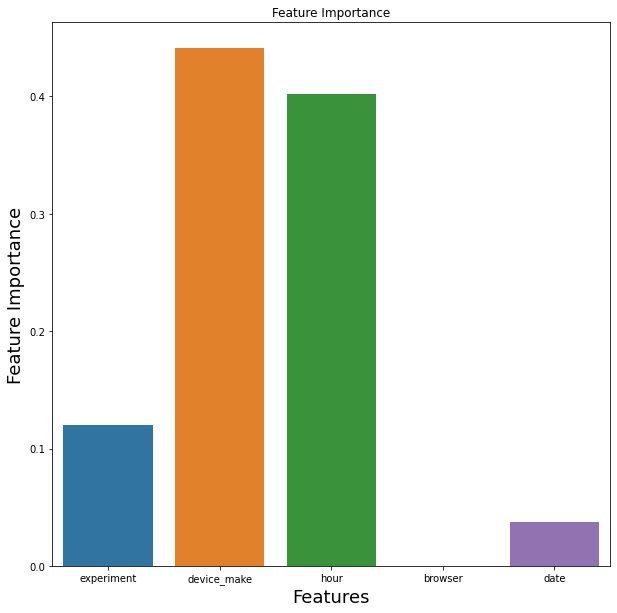

In [33]:
feature_importance,_ = decisionTreeModel.get_feature_importance()
feature_importance

Device_make and hour are the features with the highest importance. Experiment and date have lower importances while browser has no significance in determing the target

##### 2.1 Logistic Regression training with platform_android dataset 

In [34]:
feature_cols = ['experiment', 'device_make', 'hour', 'platform_os', 'date']
X = enc_platform_android[feature_cols]
Y = enc_platform_android[['aware']]

split_size = (.7, .2, .1)
X_train, X_test, y_train, y_test, val_x,val_y = Utils.split_train_test_val(X, Y, split_size)

In [35]:
logisticRegressionModel = models.LogisticRegressionModel(X_train, y_train, X_test, y_test)
folds = 5
model, accuracy, confusion_matrix = logisticRegressionModel.train(folds,'LogisticRegression experiment with platform_android data')

2022/05/21 18:46:18 INFO mlflow.tracking.fluent: Experiment with name 'LogisticRegression experiment with platform_android data' does not exist. Creating a new experiment.


step 0: Validation Accuracy of LogesticRegression is: 0.570
step 0: Validation Loss of LogesticRegression is: 0.656

step 1: Validation Accuracy of LogesticRegression is: 0.558
step 1: Validation Loss of LogesticRegression is: 0.665

step 2: Validation Accuracy of LogesticRegression is: 0.605
step 2: Validation Loss of LogesticRegression is: 0.629

step 3: Validation Accuracy of LogesticRegression is: 0.526
step 3: Validation Loss of LogesticRegression is: 0.688

step 4: Validation Accuracy of LogesticRegression is: 0.532
step 4: Validation Loss of LogesticRegression is: 0.684



2022/05/21 18:47:32 INFO mlflow.tracking.fluent: Experiment with name 'LogisticRegression with platform_android' does not exist. Creating a new experiment.
Successfully registered model 'lr_platform_android'.
2022/05/21 18:47:35 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: lr_platform_android, version 1
Created version '1' of model 'lr_platform_android'.


Run - Summary is logged to Experiment - LogisticRegression with platform_android


{'accuracy': 0.53,
 'precision': 0.64,
 'recall': 0.27,
 'true_pos': 47,
 'true_neg': 18,
 'false_pos': 10,
 'false_neg': 48}

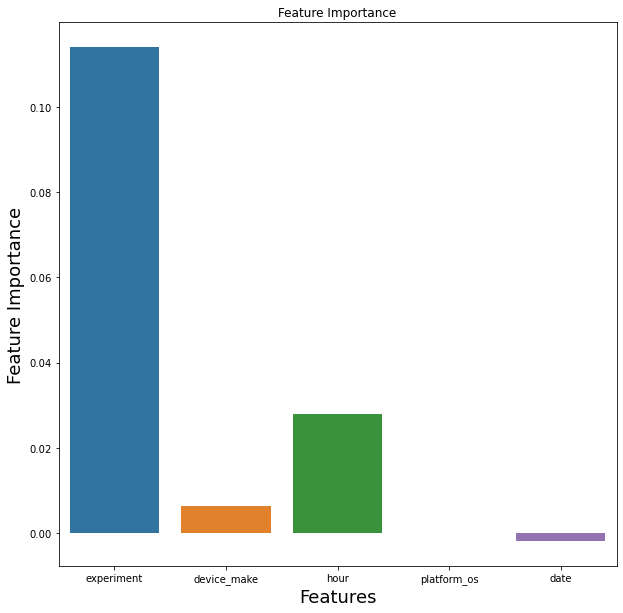

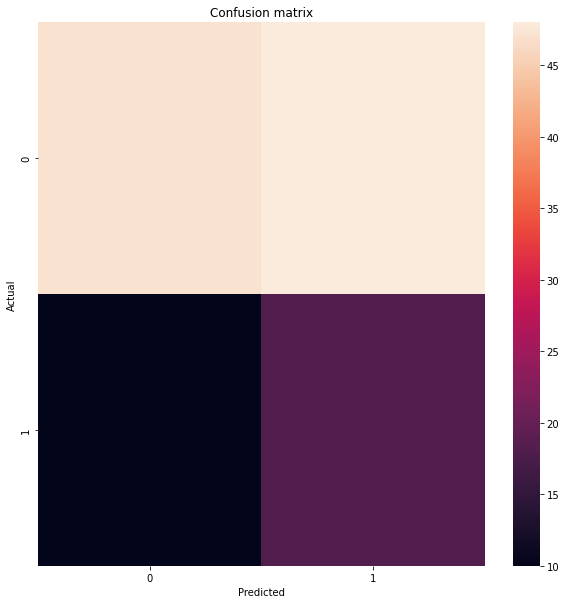

In [36]:
logisticRegressionModel.log_model(val_x, val_y, "LogisticRegression with platform_android", 'Summary', 'lr_platform_android')

The feature importance graph indicates that all features except platform_os predict for a target value of 1. This is because all of the values are positive. The degree to which they predict varies and experiment has the highest importance in predicting a target class of 1.

##### 2.2 Logistic Regression training with platform_ios dataset 

In [40]:
feature_cols = ['experiment', 'device_make', 'hour', 'platform_os', 'date']
X = enc_platform_ios[feature_cols]
Y = enc_platform_ios[['aware']]

split_size = (.7, .2, .1)
X_train, X_test, y_train, y_test, val_x,val_y = Utils.split_train_test_val(X, Y, split_size)

In [38]:
logisticRegressionModel = models.LogisticRegressionModel(X_train, y_train, X_test, y_test)
folds = 5
model, accuracy, confusion_matrix = logisticRegressionModel.train(folds,'LogisticRegression experiment with platform_ios data')

2022/05/21 18:49:59 INFO mlflow.tracking.fluent: Experiment with name 'LogisticRegression experiment with platform_ios data' does not exist. Creating a new experiment.


step 0: Validation Accuracy of LogesticRegression is: 0.667
step 0: Validation Loss of LogesticRegression is: 0.577

step 1: Validation Accuracy of LogesticRegression is: 0.500
step 1: Validation Loss of LogesticRegression is: 0.707

step 2: Validation Accuracy of LogesticRegression is: 0.500
step 2: Validation Loss of LogesticRegression is: 0.707

step 3: Validation Accuracy of LogesticRegression is: 1.000
step 3: Validation Loss of LogesticRegression is: 0.000

step 4: Validation Accuracy of LogesticRegression is: 1.000
step 4: Validation Loss of LogesticRegression is: 0.000



In [39]:
logisticRegressionModel.log_model(val_x, val_y, "LogisticRegression with platform_ios", 'Summary', 'lr_platform_ios')

IndexError: index 1 is out of bounds for axis 0 with size 1

##### 2.3 Logistic Regression training with browser chrome_mobile dataset 

In [42]:
feature_cols = ['experiment', 'device_make', 'hour', 'browser', 'date']
X = enc_browser_chromemobile[feature_cols]
Y = enc_browser_chromemobile[['aware']]

split_size = (.7, .2, .1)
X_train, X_test, y_train, y_test, val_x,val_y = Utils.split_train_test_val(X, Y, split_size)

In [44]:
logisticRegressionModel = models.LogisticRegressionModel(X_train, y_train, X_test, y_test)
folds = 5
model, accuracy, confusion_matrix = logisticRegressionModel.train(folds,'LogisticRegression experiment with browser chrome_mobile data')

2022/05/21 18:53:10 INFO mlflow.tracking.fluent: Experiment with name 'LogisticRegression experiment with browser chrome_mobile data' does not exist. Creating a new experiment.


step 0: Validation Accuracy of LogesticRegression is: 0.490
step 0: Validation Loss of LogesticRegression is: 0.714

step 1: Validation Accuracy of LogesticRegression is: 0.557
step 1: Validation Loss of LogesticRegression is: 0.666

step 2: Validation Accuracy of LogesticRegression is: 0.557
step 2: Validation Loss of LogesticRegression is: 0.666

step 3: Validation Accuracy of LogesticRegression is: 0.619
step 3: Validation Loss of LogesticRegression is: 0.618

step 4: Validation Accuracy of LogesticRegression is: 0.557
step 4: Validation Loss of LogesticRegression is: 0.666



2022/05/21 18:53:44 INFO mlflow.tracking.fluent: Experiment with name 'LogisticRegression with browser chrome_mobile' does not exist. Creating a new experiment.
Successfully registered model 'lr_browser_chrome_mobile'.
2022/05/21 18:53:46 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: lr_browser_chrome_mobile, version 1
Created version '1' of model 'lr_browser_chrome_mobile'.


Run - Summary is logged to Experiment - LogisticRegression with browser chrome_mobile


{'accuracy': 0.41,
 'precision': 0.25,
 'recall': 0.05,
 'true_pos': 27,
 'true_neg': 2,
 'false_pos': 6,
 'false_neg': 35}

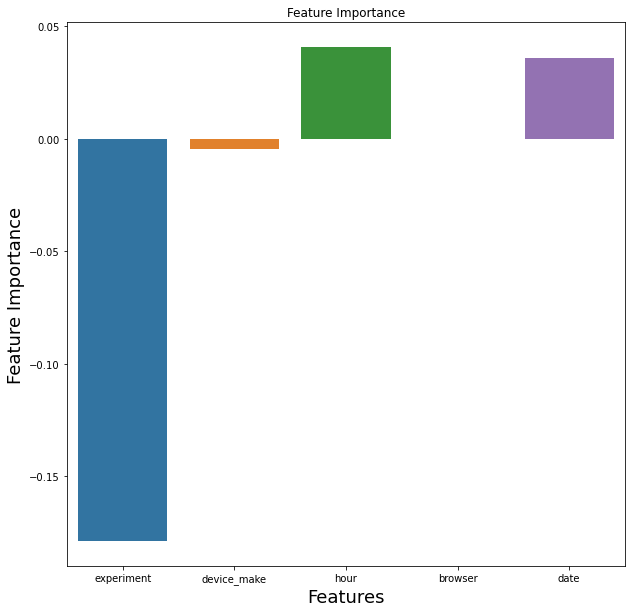

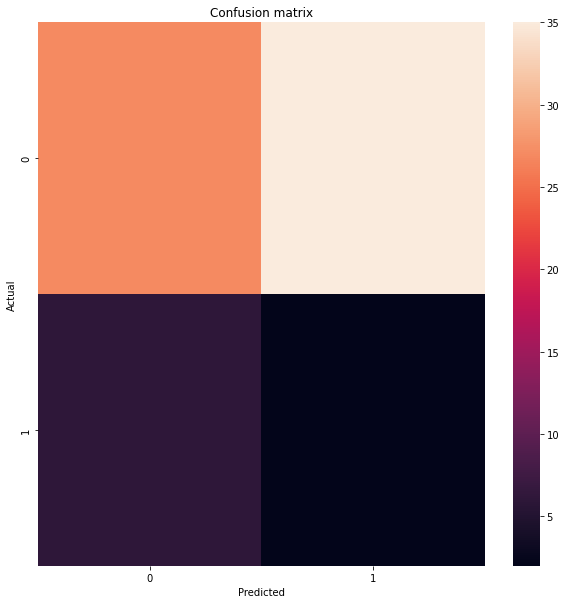

In [45]:
logisticRegressionModel.log_model(val_x, val_y, "LogisticRegression with browser chrome_mobile", 'Summary', 'lr_browser_chrome_mobile')

From the feature importance graph we can see that the experiment feature contributes highly in predicting a target class of 0(not aware). The other features device_make, hour and date predict a target class of 1(aware).

##### 2.4 Logistic Regression training with browser chrome_mobile_webview dataset 

In [46]:
feature_cols = ['experiment', 'device_make', 'hour', 'browser', 'date']
X = enc_browser_chromemobile_webview[feature_cols]
Y = enc_browser_chromemobile_webview[['aware']]

split_size = (.7, .2, .1)
X_train, X_test, y_train, y_test, val_x,val_y = Utils.split_train_test_val(X, Y, split_size)

In [47]:
logisticRegressionModel = models.LogisticRegressionModel(X_train, y_train, X_test, y_test)
folds = 5
model, accuracy, confusion_matrix = logisticRegressionModel.train(folds,'LogisticRegression experiment with browser chrome_mobile_webview data')

2022/05/21 19:03:58 INFO mlflow.tracking.fluent: Experiment with name 'LogisticRegression experiment with browser chrome_mobile_webview data' does not exist. Creating a new experiment.


step 0: Validation Accuracy of LogesticRegression is: 0.469
step 0: Validation Loss of LogesticRegression is: 0.729

step 1: Validation Accuracy of LogesticRegression is: 0.500
step 1: Validation Loss of LogesticRegression is: 0.707

step 2: Validation Accuracy of LogesticRegression is: 0.438
step 2: Validation Loss of LogesticRegression is: 0.750

step 3: Validation Accuracy of LogesticRegression is: 0.613
step 3: Validation Loss of LogesticRegression is: 0.622

step 4: Validation Accuracy of LogesticRegression is: 0.387
step 4: Validation Loss of LogesticRegression is: 0.783



2022/05/21 19:04:25 INFO mlflow.tracking.fluent: Experiment with name 'LogisticRegression with browser chrome_mobile_webview' does not exist. Creating a new experiment.
Successfully registered model 'lr_browser_chrome_mobile_webview'.
2022/05/21 19:04:29 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: lr_browser_chrome_mobile_webview, version 1
Created version '1' of model 'lr_browser_chrome_mobile_webview'.


Run - Summary is logged to Experiment - LogisticRegression with browser chrome_mobile_webview


{'accuracy': 0.57,
 'precision': 0.59,
 'recall': 0.77,
 'true_pos': 3,
 'true_neg': 10,
 'false_pos': 7,
 'false_neg': 3}

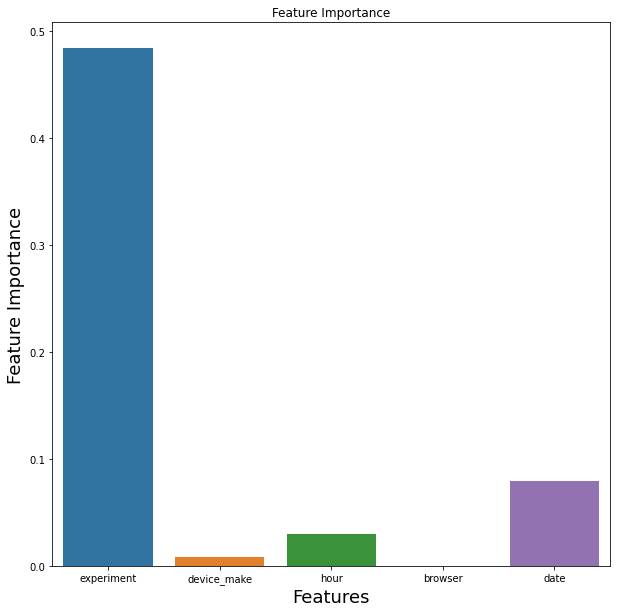

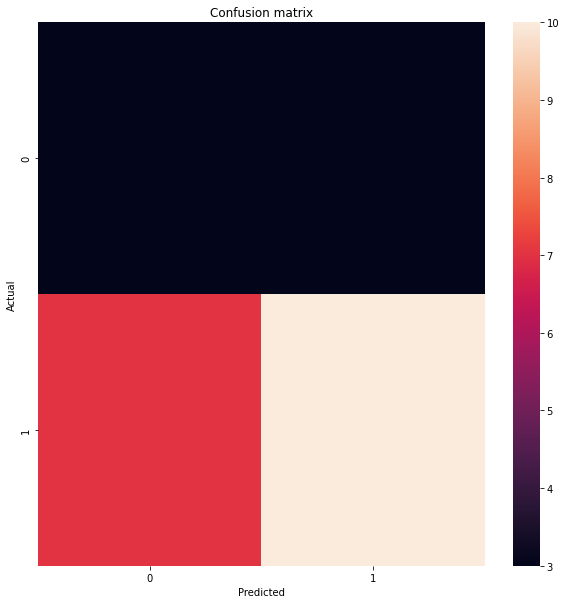

In [48]:
logisticRegressionModel.log_model(val_x, val_y, "LogisticRegression with browser chrome_mobile_webview", 'Summary', 'lr_browser_chrome_mobile_webview')

The feature importance graph indicates that all features except browser predict for a target value of 1. This is because all of the values are positive. The degree to which they predict varies and experiment has the highest significane in predicting a target class of 1(aware).

##### 3.1 Logistic Regression training with platform_android dataset 